# モジュールのインポート

In [1]:
#モジュールのインポート
%matplotlib inline
from scipy.optimize import curve_fit #フィッティングに使う
import numpy as np #いつもの
import matplotlib.pyplot as plt #プロット用
from scipy.special import erf #2ステップ関数用の誤差関数
from scipy.integrate import simps #シンプソン法による積分用
from scipy.interpolate import make_interp_spline #スプライン関数

print("ok")

ok


# データの読み込み・プロット確認

In [665]:
#データの読み込み
plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#データパスの入力#################################################################################################
Filename='XMCD'
filename='Ni60Co40_100_Ni'
path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/解析'

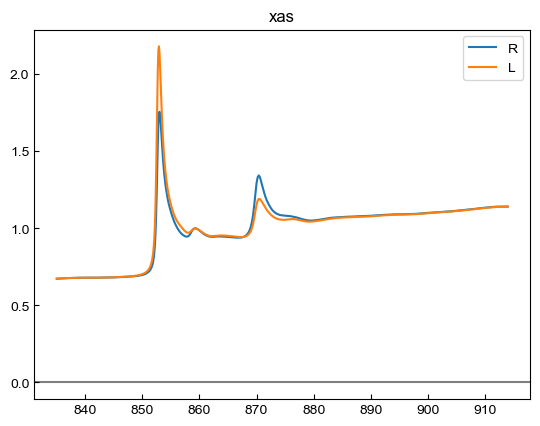

In [666]:
#保存先の指定#################################################################################################
save_path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/論文作成/fig/XMCD'

#データの読み込み##############################################################################################
f=open(f'{path}/{Filename}/{filename}.txt','rt')
energy_list=[]  #Photon energy
x1_list=[]  #absorption
x2_list=[]

for i in range(1):
    next(f)
n=0
for line in f :
    n = n + 1
    data = line[:-1].split('\t')
    energy_list.append(float(data[1])) #1Photon Energy (eV)
    x1_list.append(float(data[14])) #14R, 15L, 16XAS, 17XMCD
    x2_list.append(float(data[15])) #14R, 15L, 16XAS, 17XMCD
    
energy = np.array( energy_list )
xasrp = np.array( x1_list )
xaslp = np.array( x2_list )

#MCD&XASスペクトルのプロット####################################################
plt.plot(energy, xasrp,label='R')
plt.plot(energy, xaslp,label='L')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("xas")
plt.legend()
plt.show()

In [667]:
# pre-edgeとpost-edgeの領域を定義 #######################################################
pre_edge_range = (835, 848)  # 適切なエネルギー範囲に変更
post_edge_range = (901,909)

pre_0_start = 849
post_0_start = 890

In [668]:
# BGの読み込み

#データパスの入力#################################################################################################
Filename='XMCD'
filename_bg='Co_110_PR_BG_lim'
path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/解析'

#データの読み込み##############################################################################################
f=open(f'{path}/{Filename}/{filename_bg}.txt','rt')
energybg_list=[]  #Photon energy
ybg_list=[]  #absorption

for i in range(1):
    next(f)
n=0
for line in f :
    n = n + 1
    data = line[:-1].split('\t')
    energybg_list.append(float(data[1])) #1Photon Energy (eV)
    ybg_list.append(float(data[4])) #14R, 15L, 16XAS, 17XMCD
    
energybg = np.array( energybg_list )
bg = np.array( ybg_list )
#plt.plot(energybg,bg,'o-')
#plt.show()

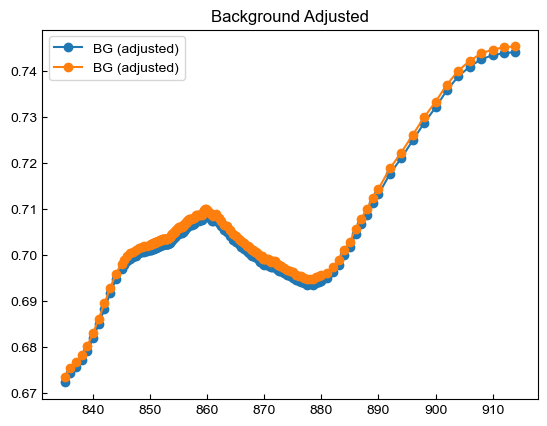

In [669]:
# スプライン補間のための関数を定義
from scipy.interpolate import make_interp_spline

# エネルギー範囲の補間を行う関数
def interpolate_to_match_energy(energy_source, data_source, energy_target):
    spline = make_interp_spline(energy_source, data_source, k=3)  # スプライン補間
    data_interpolated = spline(energy_target)
    return data_interpolated

# BGデータをXASのエネルギーに補間してデータ点を一致させる
bg_interpolated = interpolate_to_match_energy(energybg, bg, energy)

# データのフィルタリング
pre_edge_indices = (energy >= pre_edge_range[0]) & (energy <= pre_edge_range[1])
post_edge_indices = (energy >= post_edge_range[0]) & (energy <= post_edge_range[1])

bg_offsetr = xasrp[0]/bg_interpolated[0]
bg_offsetl = xaslp[0]/bg_interpolated[0]

# BGにオフセットを追加
bg_adjustedr = bg_interpolated*bg_offsetr
bg_adjustedl = bg_interpolated*bg_offsetl

# 調整後のBGをプロット
plt.plot(energy, bg_adjustedr, 'o-', label='BG (adjusted)')
plt.plot(energy, bg_adjustedl, 'o-', label='BG (adjusted)')
#plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("Background Adjusted")
plt.legend()
plt.show()

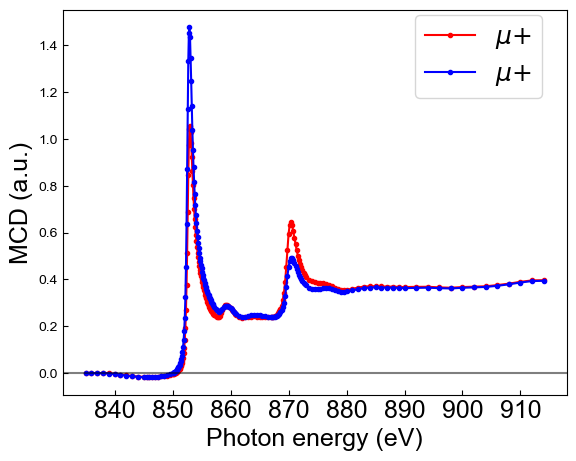

In [670]:
xasr = xasrp - bg_adjustedr
xasl = xaslp - bg_adjustedl
fig=plt.figure(figsize=(6.5, 5))
plt.plot(energy,xasr,'o-',ms=3,color='RED',label='$\mu \plus$')
plt.plot(energy,xasl,'o-',ms=3,color='BLUE',label='$\mu \plus$')
plt.xticks(fontsize=18)
plt.yticks()
plt.xlabel('Photon energy (eV)', fontsize=18)
plt.ylabel('MCD (a.u.)', fontsize=18)
plt.axhline( y=0 , xmin=0 , xmax=1000  ,linestyle="-", color="black",alpha=0.5)
plt.legend(bbox_to_anchor=(0.65, 1.05), loc='upper left', borderaxespad=1, fontsize=18)
plt.show()

## preとpost-edgeのフィッティング

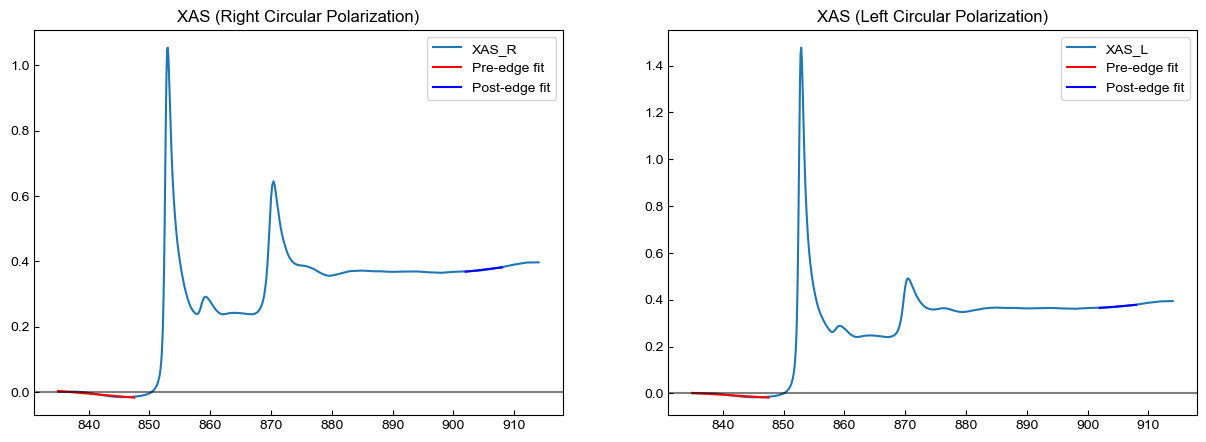

In [671]:
# 線形関数の定義
def linear(x, a, b):
    return a * x + b

# データのフィルタリング
pre_edge_indices = (energy >= pre_edge_range[0]) & (energy <= pre_edge_range[1])
post_edge_indices = (energy >= post_edge_range[0]) & (energy <= post_edge_range[1])

# pre-edgeとpost-edgeのデータ抽出
pre_edge_pe = energy[pre_edge_indices]
pre_edge_xasr = xasr[pre_edge_indices]  
pre_edge_xasl = xasl[pre_edge_indices]

post_edge_pe = energy[post_edge_indices]
post_edge_xasr = xasr[post_edge_indices]  
post_edge_xasl = xasl[post_edge_indices]

# pre-edgeのフィッティング
popt_prer, _ = curve_fit(linear, pre_edge_pe, pre_edge_xasr)
#print(f"pre-edgeの一次関数: y = {popt_prer[0]} * x + {popt_prer[1]}")
# post-edgeのフィッティング
popt_postr, _ = curve_fit(linear, post_edge_pe, post_edge_xasr)
#print(f"post-edgeの一次関数: y = {popt_postr[0]} * x + {popt_postr[1]}")
# pre-edgeのフィッティング
popt_prel, _ = curve_fit(linear, pre_edge_pe, pre_edge_xasl)
#print(f"pre-edgeの一次関数: y = {popt_prel[0]} * x + {popt_prel[1]}")
# post-edgeのフィッティング
popt_postl, _ = curve_fit(linear, post_edge_pe, post_edge_xasl)
#print(f"post-edgeの一次関数: y = {popt_postl[0]} * x + {popt_postl[1]}")

# フィッティング結果をプロット
fig=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(energy, xasr, label='XAS_R')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prer), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, linear(post_edge_pe, *popt_postr), label='Post-edge fit', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(energy, xasl, label='XAS_L')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prel), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, linear(post_edge_pe, *popt_postl), label='Post-edge fit', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Left Circular Polarization)")
plt.legend()

plt.show()

## フィッティングした関数を延長

L3吸収端のエネルギー: 853.000637037156 eV


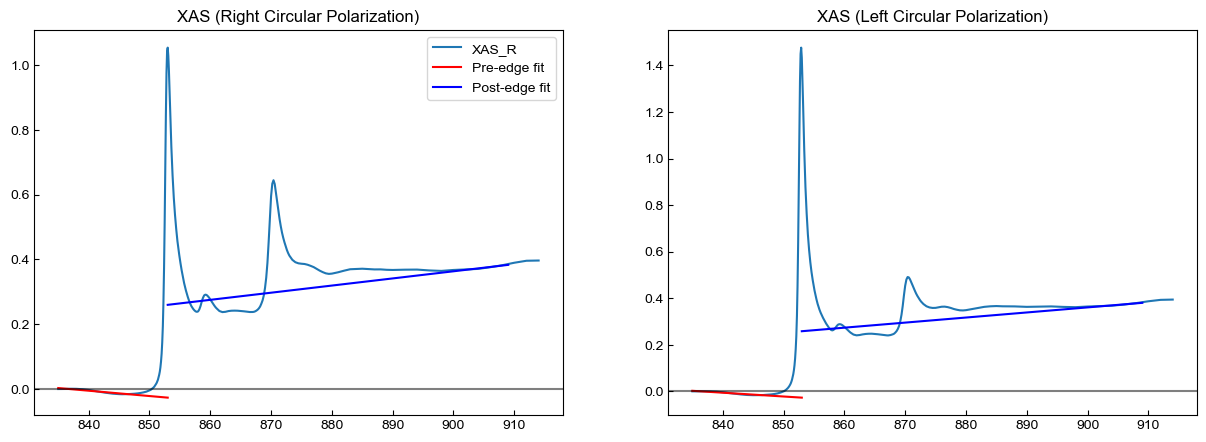

In [672]:
# L3吸収端の最大ピークを特定
L3_peak_energy = energy[np.argmax(xasr)]  # XAS_Rの最大値のエネルギーを取得
print(f"L3吸収端のエネルギー: {L3_peak_energy} eV")

# pre-edge fitとpost-edge fitをL3吸収端まで外挿
extended_pre_edge_energy = np.linspace(pre_edge_range[0], L3_peak_energy, 100)
extended_post_edge_energy = np.linspace(L3_peak_energy, post_edge_range[1], 100)

# フィッティング結果をプロット
fig=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(energy, xasr, label='XAS_R')
plt.plot(extended_pre_edge_energy, linear(extended_pre_edge_energy, *popt_prer), label='Pre-edge fit', color='red')
plt.plot(extended_post_edge_energy, linear(extended_post_edge_energy, *popt_postr), label='Post-edge fit', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(energy, xasl, label='XAS_L')
plt.plot(extended_pre_edge_energy, linear(extended_pre_edge_energy, *popt_prel), label='Pre-edge fit', color='red')
plt.plot(extended_post_edge_energy, linear(extended_post_edge_energy, *popt_postl), label='Post-edge fit', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Left Circular Polarization)")

plt.show()

## 2つの関数をつなげる

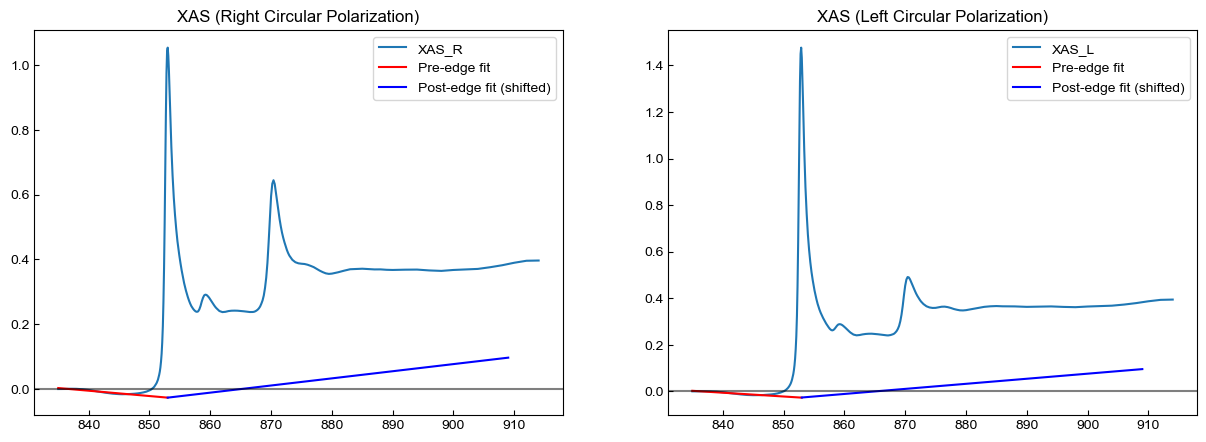

In [673]:
# pre-edge fitとpost-edge fitをL3吸収端まで外挿
extended_pre_edge_energy = np.linspace(pre_edge_range[0], L3_peak_energy, 100)
extended_post_edge_energy = np.linspace(L3_peak_energy, post_edge_range[1], 100)

# L3吸収端でのpre-edgeのy値
L3_pre_edge_y = linear(L3_peak_energy, *popt_prer)

# post-edge fitを下に平行移動させてpre-edge fitとつなげる
post_shiftr = L3_pre_edge_y - linear(L3_peak_energy, *popt_postr)
shifted_post_edge_fitr = linear(extended_post_edge_energy, *popt_postr) + post_shiftr

post_shiftl = L3_pre_edge_y - linear(L3_peak_energy, *popt_postl)
shifted_post_edge_fitl = linear(extended_post_edge_energy, *popt_postl) + post_shiftl

# フィッティング結果をプロット
fig=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(energy, xasr, label='XAS_R')
plt.plot(extended_pre_edge_energy, linear(extended_pre_edge_energy, *popt_prer), label='Pre-edge fit', color='red')
plt.plot(extended_post_edge_energy, shifted_post_edge_fitr, label='Post-edge fit (shifted)', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(energy, xasl, label='XAS_L')
plt.plot(extended_pre_edge_energy, linear(extended_pre_edge_energy, *popt_prel), label='Pre-edge fit', color='red')
plt.plot(extended_post_edge_energy, shifted_post_edge_fitl, label='Post-edge fit (shifted)', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Left Circular Polarization)")
plt.legend()
plt.show()

## 2つの関数を分離

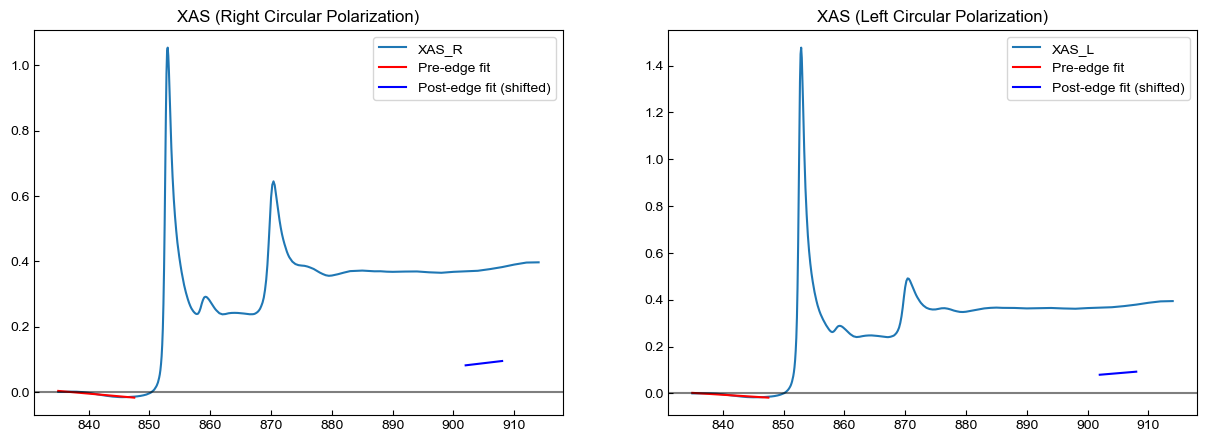

In [674]:
# post-edge fitを下に平行移動させてpre-edge fitとつなげる
post_shiftr = linear(L3_peak_energy, *popt_prer) - linear(L3_peak_energy, *popt_postr)
shifted_post_edge_fitr = linear(post_edge_pe, *popt_postr) + post_shiftr

post_shiftl = linear(L3_peak_energy, *popt_prel) - linear(L3_peak_energy, *popt_postl)
shifted_post_edge_fitl = linear(post_edge_pe, *popt_postl) + post_shiftl

# フィッティング結果をプロット (伸ばさない)
fig=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(energy, xasr, label='XAS_R')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prer), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, shifted_post_edge_fitr, label='Post-edge fit (shifted)', color='blue')  # post-edge領域のみに限定
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(energy, xasl, label='XAS_L')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prel), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, shifted_post_edge_fitl, label='Post-edge fit (shifted)', color='blue')  # post-edge領域のみに限定
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Left Circular Polarization)")
plt.legend()

plt.show()

## 補完

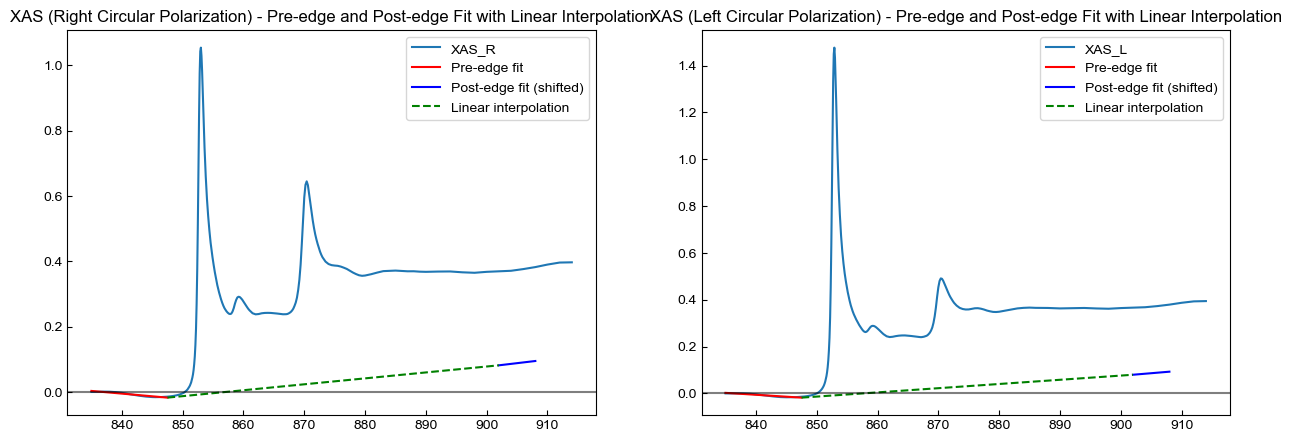

In [675]:
# スプライン補間の代わりに線形補間を使用する
spline_start = pre_edge_pe[-1]  # pre-edgeの終わり
spline_end = post_edge_pe[0]    # post-edgeの始まり

# 2点間で線形補間
interp_energy = np.linspace(spline_start, spline_end, 100)
interp_yr = np.linspace(linear(spline_start, *popt_prer), linear(spline_end, *popt_postr) + post_shiftr, 100)
interp_yl = np.linspace(linear(spline_start, *popt_prel), linear(spline_end, *popt_postl) + post_shiftl, 100)

# フィッティング結果をプロット (線形補間で接続)
fig=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(energy, xasr, label='XAS_R')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prer), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, shifted_post_edge_fitr, label='Post-edge fit (shifted)', color='blue')
plt.plot(interp_energy, interp_yr, label='Linear interpolation', color='green', linestyle='--')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization) - Pre-edge and Post-edge Fit with Linear Interpolation")
plt.legend()

plt.subplot(1,2,2)
plt.plot(energy, xasl, label='XAS_L')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prel), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, shifted_post_edge_fitl, label='Post-edge fit (shifted)', color='blue')
plt.plot(interp_energy, interp_yl, label='Linear interpolation', color='green', linestyle='--')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Left Circular Polarization) - Pre-edge and Post-edge Fit with Linear Interpolation")
plt.legend()

plt.show()

## BG引き算

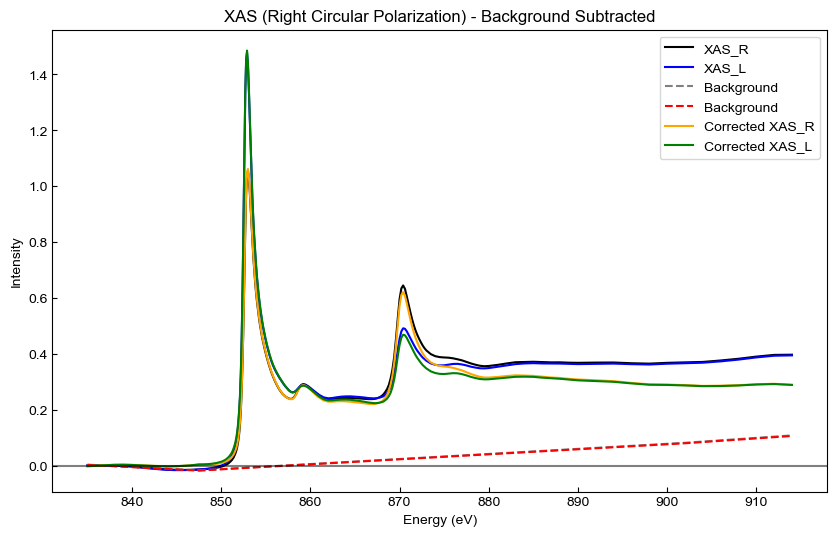

In [676]:
# バックグラウンド関数を定義
def background_function(energy, pre_params, post_params, shift, spline_start, spline_end):
    pre_edge_fit = linear(energy, *pre_params)
    post_edge_fit = linear(energy, *post_params) + shift
    # 補間範囲内での線形補間
    mask = (energy >= spline_start) & (energy <= spline_end)
    interp_y = np.linspace(linear(spline_start, *pre_params), linear(spline_end, *post_params) + shift, 100)
    background = np.zeros_like(energy)
    background[mask] = np.interp(energy[mask], np.linspace(spline_start, spline_end, 100), interp_y)
    # 補間範囲外では、pre-edgeフィットまたはpost-edgeフィットを使用
    background[energy < spline_start] = pre_edge_fit[energy < spline_start]
    background[energy > spline_end] = post_edge_fit[energy > spline_end]
    return background

# バックグラウンド関数の計算
backgroundr = background_function(energy, popt_prer, popt_postr, post_shiftr, spline_start, spline_end)
backgroundl = background_function(energy, popt_prel, popt_postl, post_shiftl, spline_start, spline_end)


# XAS_Rからバックグラウンドを引く
xas_r_corrected = xasr - backgroundr
xas_l_corrected = xasl - backgroundl

# プロット
plt.figure(figsize=(10, 6))
plt.plot(energy, xasr, label='XAS_R', color='black')
plt.plot(energy, xasl, label='XAS_L', color='blue')
plt.plot(energy, backgroundr, label='Background', color='grey', linestyle='--')
plt.plot(energy, backgroundl, label='Background', color='RED', linestyle='--')
plt.plot(energy, xas_r_corrected, label='Corrected XAS_R', color='orange')
plt.plot(energy, xas_l_corrected, label='Corrected XAS_L', color='green')

plt.axhline(y=0, xmin=0, xmax=1, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization) - Background Subtracted")
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity")
plt.legend()

plt.show()

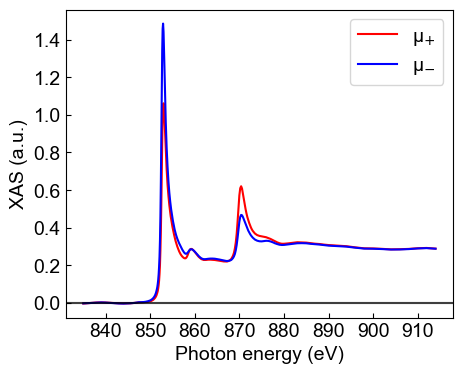

In [677]:
# プロット
fig = plt.figure(figsize=(5, 4))
plt.plot(energy, xas_r_corrected, label='μ$_{\plus}$', color='RED')
plt.plot(energy, xas_l_corrected, label='μ$_{\minus}$', color='BLUE')
plt.axhline(y=0, xmin=0, xmax=1, linestyle="-", color="black", alpha=0.5)
plt.xlabel('Photon energy (eV)', fontsize=14)
plt.ylabel('XAS (a.u.)', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axhline( y=0 , xmin=0 , xmax=1000  ,linestyle="-", color="black",alpha=0.5)
plt.show()

fig.savefig(f'{save_path}/graph_XAS[100]_{filename}.png',bbox_inches="tight",format="png", pad_inches=0.1)

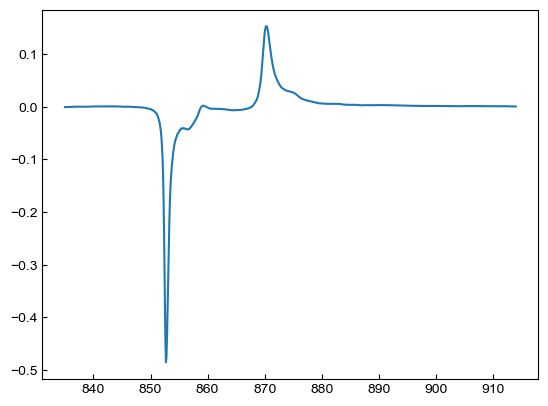

In [678]:
xmcd = xas_r_corrected - xas_l_corrected
plt.plot(energy,xmcd,'-',ms=3,label='100')

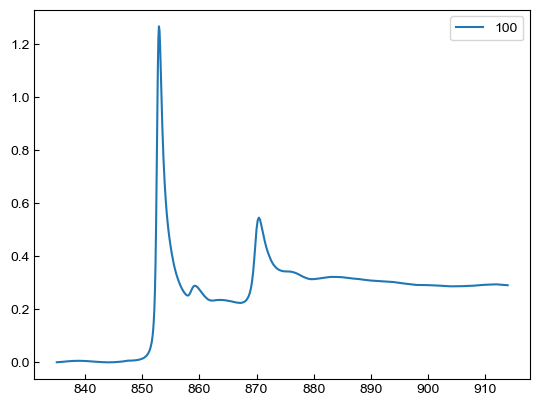

In [679]:
xas = (xas_r_corrected + xas_l_corrected)/2
plt.plot(energy, xas,label='100')
plt.legend()
plt.show()

In [680]:
def white_line_position( x, y, x0, x1 ):
    p = max([ yy for xx, yy in zip( x, y ) if x0 < xx < x1 ])
    for ix, xx in enumerate( x ):
        if x0 < xx < x1:
            if abs( y[ ix ] - p ) < 1e-7:
                break
    return ix, xx

_, e1 = white_line_position( energy, xas, 845, 860 )
_, e2 = white_line_position( energy, xas, 870, 880 )
print( e1, e2 )

852.898582796404 870.399724071603


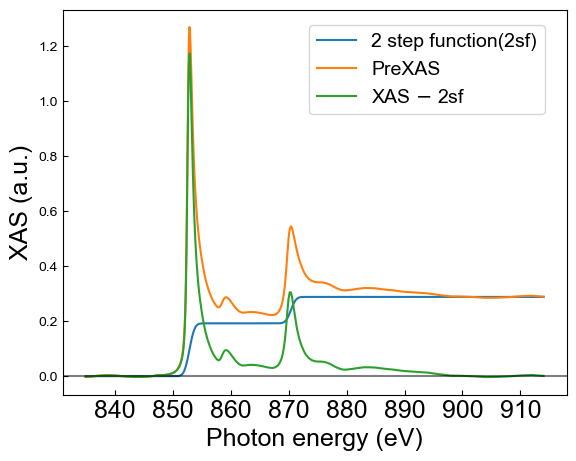

In [681]:
from scipy.special import erf

def step_func( x, x0, d ):
    return ( erf( ( x - x0 ) / d ) + 1 ) /2

def subtract_func( x, x01, x02, d, c ):
    return c * step_func( x, x01, d ) +  c/2 * step_func( x, x02, d)

def index_energy( energy, e0 ):
    for i, e in enumerate( energy ):
        if e >= e0:
            if abs( energy[ i ] - e0 ) <= abs( energy[ i - 1 ] - e0 ):
                return i
            else:
                return i - 1

i_post = index_energy( energy, post_edge_pe[0] ) #post-edgeのはじまりまで
#i_post = index_energy( energy, 880 ) #post-edgeのはじまりまで

from scipy.optimize import curve_fit
de=1

c, _ = curve_fit(
    lambda e, c: subtract_func( e, e1, e2, de, c ),
    energy[ i_post : ],
    xas[ i_post : ]
    )
subtract = subtract_func( energy, e1, e2, de, c )
t2xas = xas-subtract

fig=plt.figure(figsize=(6.5, 5))
plt.plot( energy, subtract ,label='2 step function(2sf)')
plt.plot( energy, xas ,label='PreXAS')
plt.plot( energy, t2xas ,label='XAS $\minus$ 2sf')
plt.xlabel( "Photon energy (eV)" , fontsize=18)
plt.ylabel( "XAS (a.u.)" , fontsize=18)
plt.xticks(fontsize=18)
plt.axhline( y=0 , xmin=0 , xmax=1000  ,linestyle="-", color="black",alpha=0.5)
plt.legend(bbox_to_anchor=(0.45, 1.01), loc='upper left', borderaxespad=1, fontsize=14)
plt.yticks()
#plt.xlim(880,920)
#plt.ylim(-0.1,0.1)
plt.show()

台形公式による積分結果: -4.154549833082427
累積積分の最終結果: 4.1545498330824575
r= 4.147068081688955
r1= 4.12099692476463
q= -0.2381330545970002
900 eV以降のXASの平均値r: 4.146213149637466
900 eV以降のXMCDの平均値q: -0.2381330545970002
m_orb= 0.0733778047764817
m_orb_ave= 0.07339293497719915
m_orb1= 0.07384202358033326


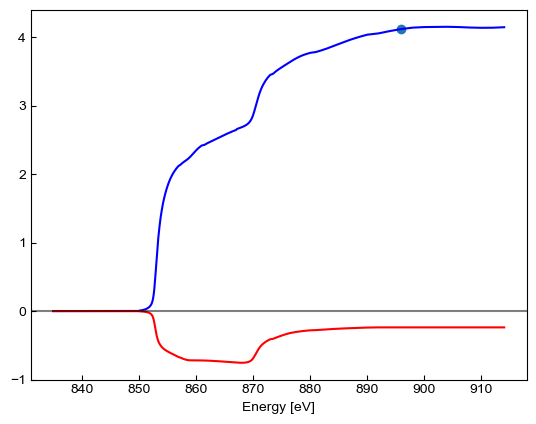

In [682]:
#積分を行ってくれる関数を定義
def integrate( x, y ):
    result = [ 0. ]
    for ix in range( len( x ) )[ 1: ]:
        result.append( simps( y[ :ix ], x[ :ix ] ) )
    return np.array( result )

#pe = 0 searchの関数の定義
def get_index( xs, x0 ):
    for i, x in enumerate( xs ):
        if x >= x0:
            if abs( xs[ i ] - x0 ) <= abs( xs[ i - 1 ] - x0 ):
                return i
            else:
                return i - 1

def index_zero( x, y, x_start, x_end ):
    iy_start = get_index( x, x_start )
    iy_end   = get_index( x, x_end )
    y_zero       = min( abs( y[ iy_start : iy_end ] ) )
    for iy, yy in enumerate( y ):
        if not iy_start <= iy <= iy_end: continue
        if abs( yy ) - y_zero <= 1e-7:
            return iy
# t2xas を 875 eV 以降で t2xas=0 となった以降で 0 に設定
def set_to_zero_after_zero_crossing(energy, t2xas, post):
    # 875 eV以降を切り出し
    post = 875
    threshold_index = get_index(energy, post)
    energy_subset = energy[threshold_index:]
    t2xas_subset = t2xas[threshold_index:]
    
    # t2xas=0 を探す
    zero_crossing_index = np.where(t2xas_subset <= 0)[0]
    if len(zero_crossing_index) > 0:
        first_zero_index = zero_crossing_index[0] + threshold_index
        t2xas[first_zero_index:] = 0
    return t2xas

# 845 eV以前の値を0にする処理################################################################3
pre_threshold_energy = pre_0_start  # エネルギーの閾値
# energyがthreshold_energy未満のインデックスを取得
pre_zero_indices = np.where(energy <= pre_threshold_energy)
# XAS (t2xas) と MCD (xmcd) の845 eV以前を0に設定
t2xas[pre_zero_indices] = 0
xmcd[pre_zero_indices] = 0

#積分
int_xas = integrate( energy, t2xas )
int_xmcd = integrate( energy, xmcd )
# 890 eV以降を0にする処理#########################################################################
threshold_energy = post_0_start  # エネルギー閾値
#threshold_energy_xas = 900 

zero_indices = np.where(energy >= threshold_energy) # energyがthreshold_energy以上のインデックスを取得
t2xas = set_to_zero_after_zero_crossing(energy, t2xas, 875) # XASスペクトル（xmcd）の890 eV以降を0に設定
#int_xas[zero_indices_xas] = int_xas[zero_indices_xas[0][0]]  # 積分値を維持（最後の値を保持)
# MCDスペクトル（xmcd）の890 eV以降を0に設定
#t2xas[zero_indices] = 0
xmcd[zero_indices] = 0
int_xmcd[zero_indices] = int_xmcd[zero_indices[0][0]]  # 積分値を維持（最後の値を保持)

#xas=0となるところまでの積分
i1_zero = index_zero( energy[ 1 : ], t2xas, 870 , 900 )

# 台形公式で積分を計算
integral = np.trapz(energy, t2xas)
# 積分の累積計算
cumulative_integral = np.array([np.trapz(y=t2xas[:i+1], x=energy[:i+1]) for i in range(len(energy))])

# postedge start eV以降のXASとXMCDの平均値を計算
i_900eV = get_index(energy, post_edge_range[0])  # 900 eV以降のインデックス取得
avg_int_xas_after_900 = np.mean(int_xas[i_900eV:])
avg_int_xmcd_after_900 = np.mean(int_xmcd[i_900eV:])

print(f"台形公式による積分結果: {integral}")
print(f"累積積分の最終結果: {cumulative_integral[-1]}")

#総和則の係数
r1 = int_xas[ i1_zero ] 
r = int_xas[-1] 
q = int_xmcd[-1]
r_ave = avg_int_xas_after_900
q_ave = avg_int_xmcd_after_900

m_orb=-4*(q)*1.66/(3*(r))/ (2*np.cos(np.radians(30)))
m_orb1=-4*(q)*1.66/(3*(r1))/ (2*np.cos(np.radians(30)))
m_orb_ave=-4*(q_ave)*1.66/(3*(r_ave))/ (2*np.cos(np.radians(30)))

print( 'r=' , r )
print( 'r1=' , r1 )
print( 'q=' , q ) 
print(f"900 eV以降のXASの平均値r: {avg_int_xas_after_900}")
print(f"900 eV以降のXMCDの平均値q: {avg_int_xmcd_after_900}")
print( 'm_orb=' , m_orb)
print( 'm_orb_ave=' , m_orb_ave)
print( 'm_orb1=' , m_orb1)

plt.plot( energy[i1_zero] , r1 , 'o')
plt.plot( energy, int_xas, 'blue')
plt.plot( energy, int_xmcd ,'red')
plt.xlabel( "Energy [eV]" )
plt.axhline( y=0 , xmin=0 , xmax=100  ,linestyle="-", color="black", alpha=0.5)
plt.show()

(835, 848)
(901, 909)
849
890
p= -0.7519221122900999
q= -0.2381330545970002
r= 4.147068081688955
r1= 4.12099692476463

Niの文献値: spin:0.605 , orbit:0.0507 , ratio: 0.08380165289256199
全体で積分した結果
m_spin (μB) = 0.8224970312948385
m_orb = 0.0733778047764817
m_orb/m_spin = 0.08921345851056105

post-edge範囲でXAS_Intensity=0となる点までで積分した結果
m_spin1 = 0.827700492875656
m_orb1 = 0.07384202358033326
m_orb/m_spin = 0.08921345851056105

積分値を平均した結果
m_spin_ave = 0.8226666267905187
m_orb_ave = 0.07339293497719915
m_orb/m_spin_ave = 0.08921345851056105


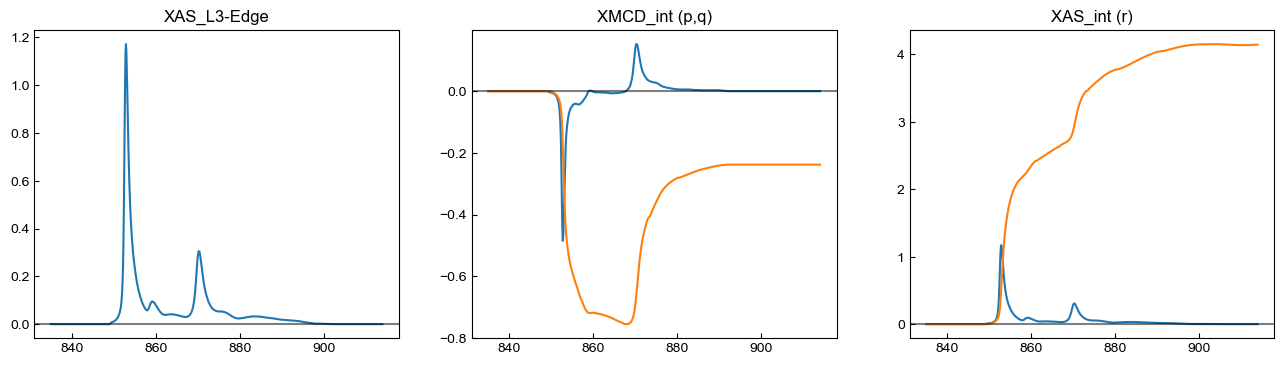

In [683]:
def get_index( xs, x0 ):
    for i, x in enumerate( xs ):
        if x >= x0:
            if abs( xs[ i ] - x0 ) <= abs( xs[ i - 1 ] - x0 ):
                return i
            else:
                return i - 1

def index_zero( x, y, x_start, x_end ):
    iy_start = get_index( x, x_start )
    iy_end   = get_index( x, x_end )
    y_zero       = min( abs( y[ iy_start : iy_end ] ) )
    for iy, yy in enumerate( y ):
        if not iy_start <= iy <= iy_end: continue
        if abs( yy ) - y_zero <= 1e-7:
            return iy

i_zero = index_zero( energy[ 1 : ], np.diff( t2xas, n=1 ), 865 , 870 )
p = int_xmcd[ i_zero ]

print(pre_edge_range)
print(post_edge_range)
print(pre_0_start)
print(post_0_start)
print( 'p=' , p )
print( 'q=' , q )
print( 'r=' , r )
print( 'r1=' , r1 )

m_spin = -( 6*p - 4*q ) * 1.66 / r / (2*np.cos(np.radians(30)))
m_spin1 = -( 6*p - 4*q ) * 1.66 / r1 / (2*np.cos(np.radians(30)))
m_spin_ave = -( 6*p - 4*q_ave ) * 1.66 / r_ave / (2*np.cos(np.radians(30)))
ratio = 0.0507 / 0.605

print('')
print( 'Niの文献値: spin:0.605 , orbit:0.0507 , ratio:' , ratio)
print('全体で積分した結果')
print( 'm_spin (μB) =' , m_spin)
print( 'm_orb =' , m_orb)
print( 'm_orb/m_spin =' , m_orb/m_spin)
print('')
print('post-edge範囲でXAS_Intensity=0となる点までで積分した結果')
print( 'm_spin1 =' , m_spin1)
print( 'm_orb1 =' , m_orb1)
print( 'm_orb/m_spin =' , m_orb1/m_spin1)
print('')
print('積分値を平均した結果')
print( 'm_spin_ave =' , m_spin_ave)
print( 'm_orb_ave =' , m_orb_ave)
print( 'm_orb/m_spin_ave =' , m_orb_ave/m_spin_ave)

fig = plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot( energy, t2xas )
#plt.plot( energy[i_zero ], t2xas[ i_zero ], "o" )
plt.axhline( y=0 , xmin=0 , xmax=100  ,linestyle="-", color="black", alpha=0.5)
plt.title("XAS_L3-Edge")

plt.subplot(1, 3, 2)
plt.plot( energy, xmcd )
#plt.plot( energy[i_zero ], xmcd[ i_zero ], "o" ) 
plt.plot( energy, int_xmcd )
#plt.plot( energy[i_zero ], int_xmcd[ i_zero ], "o" )
plt.axhline( y=0 , xmin=0 , xmax=100  ,linestyle="-", color="black", alpha=0.5)
plt.title("XMCD_int (p,q)")

plt.subplot(1, 3, 3)
plt.plot( energy, t2xas )
plt.plot( energy, int_xas )
plt.axhline( y=0 , xmin=0 , xmax=100  ,linestyle="-", color="black", alpha=0.5)
plt.title("XAS_int (r)")
plt.show()

##########データファイルの作成##################################################
with open(f'{path}/XMCD/analysis/Ni/{filename}_{post_edge_range}.txt','a') as f:
    f.write(f"pre-edge \t\t:{pre_edge_range}\n\n")
    f.write(f"post-edge \t\t:{post_edge_range}\n\n")
    f.write(f"p \t\t:{p}\n\n")
    f.write(f"q \t\t:{q}\n\n")
    f.write(f"r \t\t:{r}\n\n")
    f.write(f"r1 \t\t:{r1}\n\n")
    f.write(f"q_ave \t\t:{q_ave}\n\n")
    f.write(f"r_ave \t\t:{r_ave}\n\n")
    f.write(f"\n")
    f.write(f"Niの文献値: spin:0.605 , orbit:0.0507 , ratio:{ratio}\n")
    f.write(f"全体で積分した結果\n")
    f.write(f"m_spin (μB) =:{m_spin}\n")
    f.write(f"m_orb (μB) =:{m_orb}\n")
    f.write(f"m_orb/m_spin =:{m_orb/m_spin}\n")
    f.write(f"\n\n")
    f.write(f"post-edge範囲でXAS_Intensity=0となる点までで積分した結果\n")
    f.write(f"m_spin (μB) =:{m_spin1}\n")
    f.write(f"m_orb (μB) =:{m_orb1}\n")
    f.write(f"m_orb/m_spin =:{m_orb1/m_spin1}\n")
    f.write("\n")
    f.write(f"積分値を平均した結果\n")
    f.write(f"m_spin (μB) =:{m_spin_ave}\n")
    f.write(f"m_orb (μB) =:{m_orb_ave}\n")
    f.write(f"m_orb/m_spin =:{m_orb_ave/m_spin_ave}\n")
    f.write("\n")

#fig.savefig(f'{save_path}/{filename}_{post_edge_range}.png',format="png", bbox_inches="tight", pad_inches=0.1)

# [110]

In [727]:
#データパスの入力#################################################################################################
Filename='XMCD'
filename='Ni60Co40_110_Ni'
path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/解析'

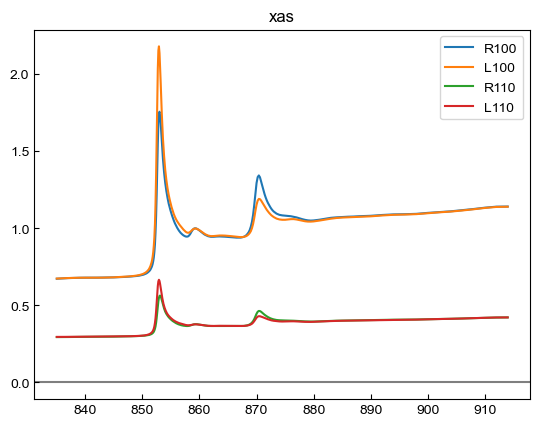

In [728]:
#保存先の指定#################################################################################################
#save_path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/解析/XMCD/fig/both'

#データの読み込み##############################################################################################
f=open(f'{path}/{Filename}/{filename}.txt','rt')
energy_list=[]  #Photon energy
x11_list=[]  #absorption
x21_list=[]

for i in range(1):
    next(f)
n=0
for line in f :
    n = n + 1
    data = line[:-1].split('\t')
    energy_list.append(float(data[1])) #1Photon Energy (eV)
    x11_list.append(float(data[14])) #14R, 15L, 16XAS, 17XMCD
    x21_list.append(float(data[15])) #14R, 15L, 16XAS, 17XMCD
    
energy = np.array( energy_list )
xasrp1 = np.array( x11_list )
xaslp1 = np.array( x21_list )
#xmcdpre = np.array( x2_list )

#MCD&XASスペクトルのプロット####################################################
plt.plot(energy, xasrp,label='R100')
plt.plot(energy, xaslp,label='L100')
plt.plot(energy, xasrp1,label='R110')
plt.plot(energy, xaslp1,label='L110')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("xas")
plt.legend()
plt.show()

In [729]:

# pre-edgeとpost-edgeの領域を定義 #######################################################
pre_edge_range = (835, 848)  # 適切なエネルギー範囲に変更
post_edge_range = (908, 915)
pre_0_start = 849
post_0_start = 890

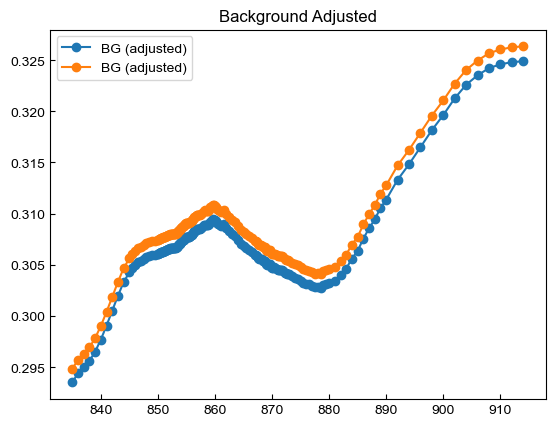

In [730]:
# スプライン補間のための関数を定義
from scipy.interpolate import make_interp_spline

# エネルギー範囲の補間を行う関数
def interpolate_to_match_energy(energy_source, data_source, energy_target):
    spline = make_interp_spline(energy_source, data_source, k=3)  # スプライン補間
    data_interpolated = spline(energy_target)
    return data_interpolated

# BGデータをXASのエネルギーに補間してデータ点を一致させる
bg_interpolated = interpolate_to_match_energy(energybg, bg, energy)

# データのフィルタリング
pre_edge_indices = (energy >= pre_edge_range[0]) & (energy <= pre_edge_range[1])
post_edge_indices = (energy >= post_edge_range[0]) & (energy <= post_edge_range[1])

# Pre-edge領域でのXASとBGの平均値を計算
#xas_pre_edge_mean = np.mean((xasrp[pre_edge_indices] + xaslp[pre_edge_indices]) / 2)
#bg_pre_edge_mean = np.mean(bg_interpolated[pre_edge_indices])

# XASのpre-edge領域に合わせるためのBGのオフセットを計算
#bg_offset = xas_pre_edge_mean - bg_pre_edge_mean

bg_offsetr = xasrp1[0]/bg_interpolated[0]
bg_offsetl = xaslp1[0]/bg_interpolated[0]

# BGにオフセットを追加
bg_adjustedr = bg_interpolated*bg_offsetr
bg_adjustedl = bg_interpolated*bg_offsetl

# 調整後のBGをプロット
plt.plot(energy, bg_adjustedr, 'o-', label='BG (adjusted)')
plt.plot(energy, bg_adjustedl, 'o-', label='BG (adjusted)')
#plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("Background Adjusted")
plt.legend()
plt.show()

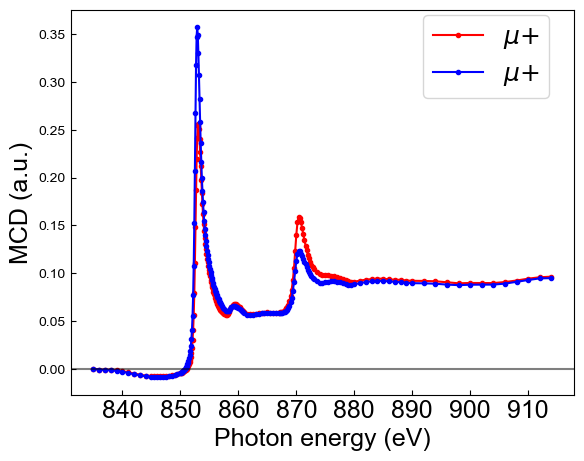

In [731]:
xasr1 = xasrp1 - bg_adjustedr
xasl1 = xaslp1 - bg_adjustedl
fig=plt.figure(figsize=(6.5, 5))
plt.plot(energy,xasr1,'o-',ms=3,color='RED',label='$\mu \plus$')
plt.plot(energy,xasl1,'o-',ms=3,color='BLUE',label='$\mu \plus$')
plt.xticks(fontsize=18)
plt.yticks()
plt.xlabel('Photon energy (eV)', fontsize=18)
plt.ylabel('MCD (a.u.)', fontsize=18)
plt.axhline( y=0 , xmin=0 , xmax=1000  ,linestyle="-", color="black",alpha=0.5)
plt.legend(bbox_to_anchor=(0.65, 1.05), loc='upper left', borderaxespad=1, fontsize=18)
plt.show()

pre-edgeの一次関数: y = -0.0007193739094076563 * x + 0.6010569306048595
post-edgeの一次関数: y = 0.0005241991952841213 * x + -0.38260575340974856
pre-edgeの一次関数: y = -0.0007703211749926639 * x + 0.6433832548364088
post-edgeの一次関数: y = 0.0004921041373695028 * x + -0.35471223264590507


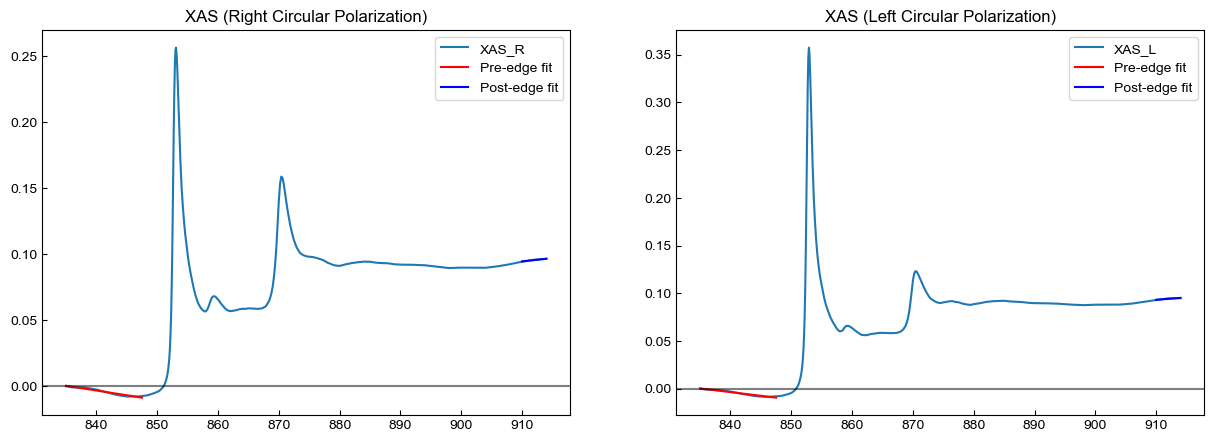

In [732]:
# 線形関数の定義
def linear(x, a, b):
    return a * x + b

# データのフィルタリング
pre_edge_indices = (energy >= pre_edge_range[0]) & (energy <= pre_edge_range[1])
post_edge_indices = (energy >= post_edge_range[0]) & (energy <= post_edge_range[1])

# pre-edgeとpost-edgeのデータ抽出
pre_edge_pe = energy[pre_edge_indices]
pre_edge_xasr1 = xasr1[pre_edge_indices]  
pre_edge_xasl1 = xasl1[pre_edge_indices]

post_edge_pe = energy[post_edge_indices]
post_edge_xasr1 = xasr1[post_edge_indices]  
post_edge_xasl1 = xasl1[post_edge_indices]

# pre-edgeのフィッティング
popt_prer1, _ = curve_fit(linear, pre_edge_pe, pre_edge_xasr1)
print(f"pre-edgeの一次関数: y = {popt_prer1[0]} * x + {popt_prer1[1]}")

# post-edgeのフィッティング
popt_postr1, _ = curve_fit(linear, post_edge_pe, post_edge_xasr1)
print(f"post-edgeの一次関数: y = {popt_postr1[0]} * x + {popt_postr1[1]}")

# pre-edgeのフィッティング
popt_prel1, _ = curve_fit(linear, pre_edge_pe, pre_edge_xasl1)
print(f"pre-edgeの一次関数: y = {popt_prel1[0]} * x + {popt_prel1[1]}")

# post-edgeのフィッティング
popt_postl1, _ = curve_fit(linear, post_edge_pe, post_edge_xasl1)
print(f"post-edgeの一次関数: y = {popt_postl1[0]} * x + {popt_postl1[1]}")

# フィッティング結果をプロット
fig=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(energy, xasr1, label='XAS_R')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prer1), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, linear(post_edge_pe, *popt_postr1), label='Post-edge fit', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(energy, xasl1, label='XAS_L')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prel1), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, linear(post_edge_pe, *popt_postl1), label='Post-edge fit', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Left Circular Polarization)")
plt.legend()

plt.show()

L3吸収端のエネルギー: 853.099622051712 eV


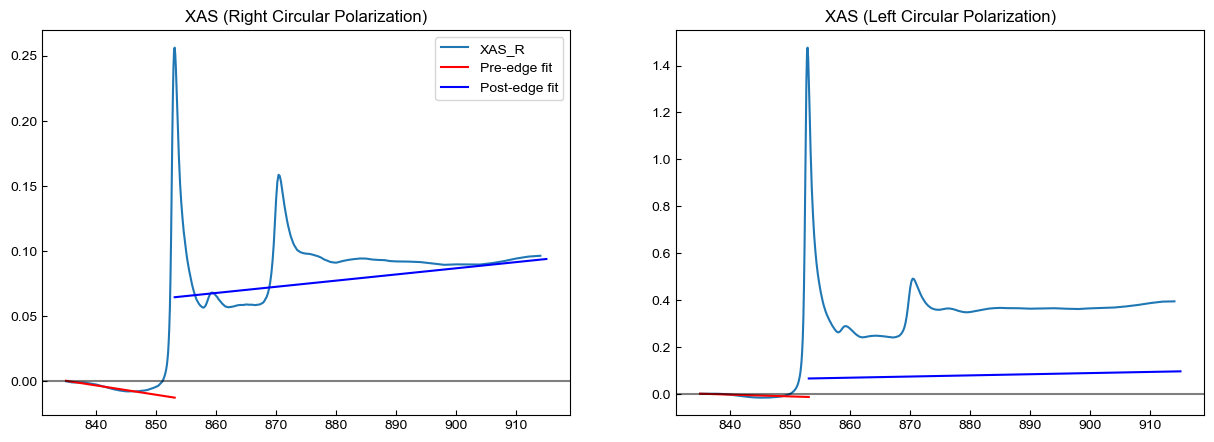

In [733]:
# L3吸収端の最大ピークを特定
L3_peak_energy1 = energy[np.argmax(xasr1)]  # XAS_Rの最大値のエネルギーを取得
print(f"L3吸収端のエネルギー: {L3_peak_energy1} eV")

# pre-edge fitとpost-edge fitをL3吸収端まで外挿
extended_pre_edge_energy1 = np.linspace(pre_edge_range[0], L3_peak_energy1, 100)
extended_post_edge_energy1 = np.linspace(L3_peak_energy1, post_edge_range[1], 100)

# フィッティング結果をプロット
fig=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(energy, xasr1, label='XAS_R')
plt.plot(extended_pre_edge_energy1, linear(extended_pre_edge_energy, *popt_prer1), label='Pre-edge fit', color='red')
plt.plot(extended_post_edge_energy1, linear(extended_post_edge_energy, *popt_postr1), label='Post-edge fit', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(energy, xasl, label='XAS_L')
plt.plot(extended_pre_edge_energy1, linear(extended_pre_edge_energy1, *popt_prel1), label='Pre-edge fit', color='red')
plt.plot(extended_post_edge_energy1, linear(extended_post_edge_energy1, *popt_postl1), label='Post-edge fit', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Left Circular Polarization)")

plt.show()

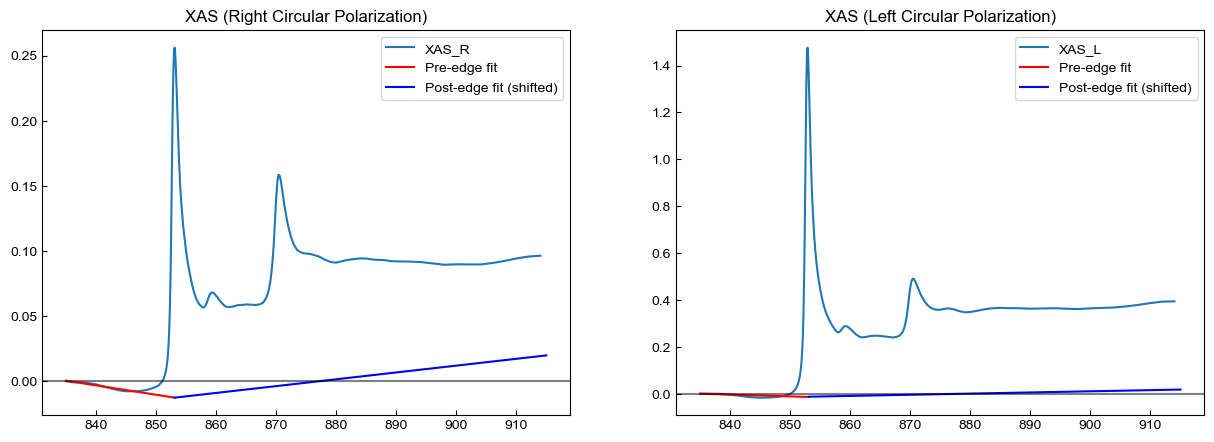

In [734]:
# L3吸収端でのpre-edgeのy値
L3_pre_edge_y1 = linear(L3_peak_energy1, *popt_prer1)

# post-edge fitを下に平行移動させてpre-edge fitとつなげる
post_shiftr1 = L3_pre_edge_y1 - linear(L3_peak_energy1, *popt_postr1)
shifted_post_edge_fitr1 = linear(extended_post_edge_energy1, *popt_postr1) + post_shiftr1

post_shiftl1 = L3_pre_edge_y1 - linear(L3_peak_energy1, *popt_postl1)
shifted_post_edge_fitl1 = linear(extended_post_edge_energy1, *popt_postl1) + post_shiftl1

# フィッティング結果をプロット
fig=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(energy, xasr1, label='XAS_R')
plt.plot(extended_pre_edge_energy1, linear(extended_pre_edge_energy1, *popt_prer1), label='Pre-edge fit', color='red')
plt.plot(extended_post_edge_energy1, shifted_post_edge_fitr1, label='Post-edge fit (shifted)', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(energy, xasl, label='XAS_L')
plt.plot(extended_pre_edge_energy1, linear(extended_pre_edge_energy1, *popt_prel1), label='Pre-edge fit', color='red')
plt.plot(extended_post_edge_energy1, shifted_post_edge_fitl1, label='Post-edge fit (shifted)', color='blue')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Left Circular Polarization)")
plt.legend()
plt.show()

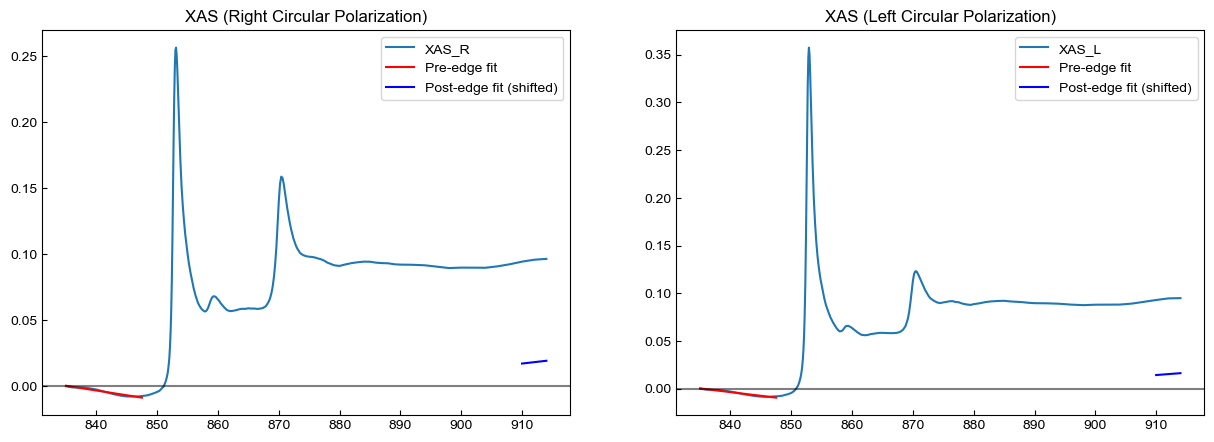

In [735]:
# post-edge fitを下に平行移動させてpre-edge fitとつなげる
post_shiftr1 = linear(L3_peak_energy1, *popt_prer1) - linear(L3_peak_energy1, *popt_postr1)
shifted_post_edge_fitr1 = linear(post_edge_pe, *popt_postr1) + post_shiftr1

post_shiftl1 = linear(L3_peak_energy1, *popt_prel1) - linear(L3_peak_energy1, *popt_postl1)
shifted_post_edge_fitl1 = linear(post_edge_pe, *popt_postl1) + post_shiftl1

# フィッティング結果をプロット (伸ばさない)
fig=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(energy, xasr1, label='XAS_R')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prer1), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, shifted_post_edge_fitr1, label='Post-edge fit (shifted)', color='blue')  # post-edge領域のみに限定
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(energy, xasl1, label='XAS_L')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prel1), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, shifted_post_edge_fitl1, label='Post-edge fit (shifted)', color='blue')  # post-edge領域のみに限定
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Left Circular Polarization)")
plt.legend()

plt.show()

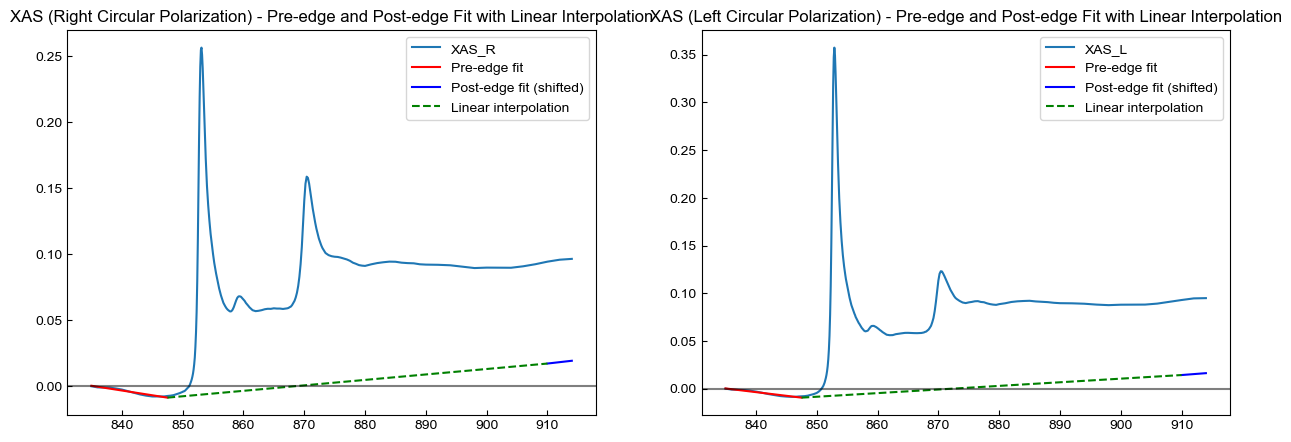

In [736]:
# スプライン補間の代わりに線形補間を使用する
spline_start = pre_edge_pe[-1]  # pre-edgeの終わり
spline_end = post_edge_pe[0]    # post-edgeの始まり

# 2点間で線形補間
interp_energy = np.linspace(spline_start, spline_end, 100)
interp_yr1 = np.linspace(linear(spline_start, *popt_prer1), linear(spline_end, *popt_postr1) + post_shiftr1, 100)
interp_yl1 = np.linspace(linear(spline_start, *popt_prel1), linear(spline_end, *popt_postl1) + post_shiftl1, 100)

# フィッティング結果をプロット (線形補間で接続)
fig=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(energy, xasr1, label='XAS_R')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prer1), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, shifted_post_edge_fitr1, label='Post-edge fit (shifted)', color='blue')
plt.plot(interp_energy, interp_yr1, label='Linear interpolation', color='green', linestyle='--')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization) - Pre-edge and Post-edge Fit with Linear Interpolation")
plt.legend()

plt.subplot(1,2,2)
plt.plot(energy, xasl1, label='XAS_L')
plt.plot(pre_edge_pe, linear(pre_edge_pe, *popt_prel1), label='Pre-edge fit', color='red')
plt.plot(post_edge_pe, shifted_post_edge_fitl1, label='Post-edge fit (shifted)', color='blue')
plt.plot(interp_energy, interp_yl1, label='Linear interpolation', color='green', linestyle='--')
plt.axhline(y=0, xmin=0, xmax=100, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Left Circular Polarization) - Pre-edge and Post-edge Fit with Linear Interpolation")
plt.legend()

plt.show()

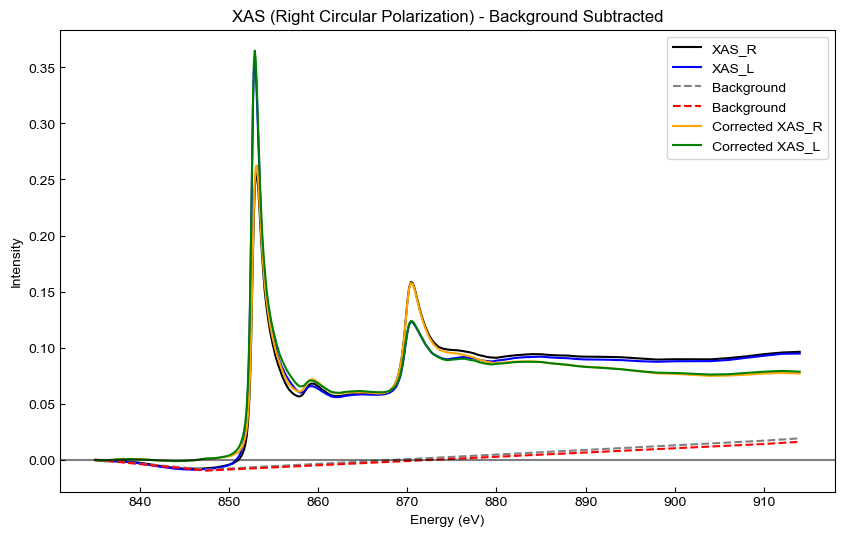

In [737]:
# バックグラウンド関数を定義
def background_function(energy, pre_params, post_params, shift, spline_start, spline_end):
    pre_edge_fit = linear(energy, *pre_params)
    post_edge_fit = linear(energy, *post_params) + shift
    # 補間範囲内での線形補間
    mask = (energy >= spline_start) & (energy <= spline_end)
    interp_y = np.linspace(linear(spline_start, *pre_params), linear(spline_end, *post_params) + shift, 100)
    background = np.zeros_like(energy)
    background[mask] = np.interp(energy[mask], np.linspace(spline_start, spline_end, 100), interp_y)
    # 補間範囲外では、pre-edgeフィットまたはpost-edgeフィットを使用
    background[energy < spline_start] = pre_edge_fit[energy < spline_start]
    background[energy > spline_end] = post_edge_fit[energy > spline_end]
    return background

# バックグラウンド関数の計算
backgroundr1 = background_function(energy, popt_prer1, popt_postr1, post_shiftr1, spline_start, spline_end)
backgroundl1 = background_function(energy, popt_prel1, popt_postl1, post_shiftl1, spline_start, spline_end)


# XAS_Rからバックグラウンドを引く
xas_r_corrected1 = xasr1 - backgroundr1
xas_l_corrected1 = xasl1 - backgroundl1

# プロット
plt.figure(figsize=(10, 6))
plt.plot(energy, xasr1, label='XAS_R', color='black')
plt.plot(energy, xasl1, label='XAS_L', color='blue')
plt.plot(energy, backgroundr1, label='Background', color='grey', linestyle='--')
plt.plot(energy, backgroundl1, label='Background', color='RED', linestyle='--')
plt.plot(energy, xas_r_corrected1, label='Corrected XAS_R', color='orange')
plt.plot(energy, xas_l_corrected1, label='Corrected XAS_L', color='green')

plt.axhline(y=0, xmin=0, xmax=1, linestyle="-", color="black", alpha=0.5)
plt.title("XAS (Right Circular Polarization) - Background Subtracted")
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity")
plt.legend()

plt.show()

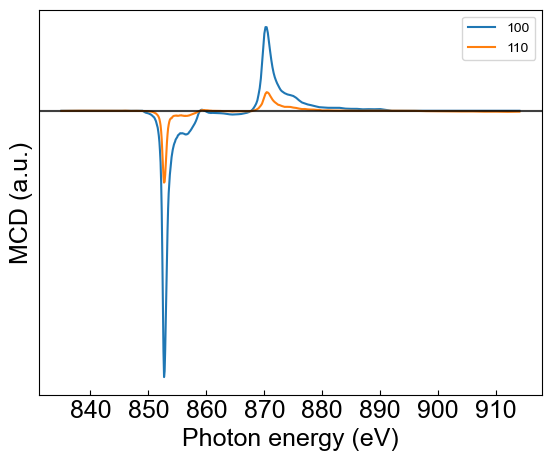

In [738]:
fig=plt.figure(figsize=(6.5, 5))

xmcd1 = xas_r_corrected1 - xas_l_corrected1
plt.plot(energy,xmcd,'-',ms=3,label='100')
plt.plot(energy,xmcd1,'-',ms=3,label='110')
plt.axhline(y=0, xmin=0, xmax=1, linestyle="-", color="black", alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks([])
plt.xlabel('Photon energy (eV)', fontsize=18)
plt.ylabel('MCD (a.u.)', fontsize=18)
plt.axhline( y=0 , xmin=0 , xmax=1000  ,linestyle="-", color="black",alpha=0.5)
plt.legend()
plt.show()

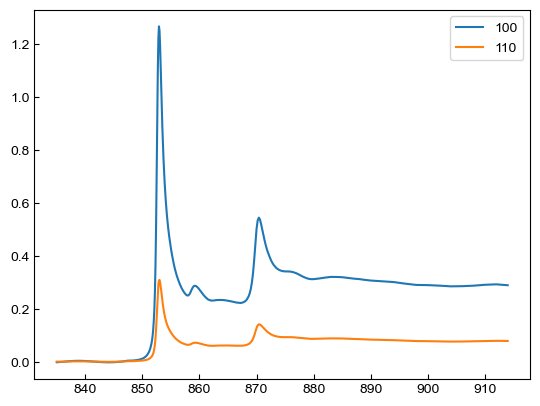

In [739]:
xas1 = (xas_r_corrected1 + xas_l_corrected1)/2
plt.plot(energy, xas,label='100')
plt.plot(energy, xas1,label='110')
plt.legend()
plt.show()

In [740]:
def white_line_position( x, y, x0, x1 ):
    p = max([ yy for xx, yy in zip( x, y ) if x0 < xx < x1 ])
    for ix, xx in enumerate( x ):
        if x0 < xx < x1:
            if abs( y[ ix ] - p ) < 1e-7:
                break
    return ix, xx

_, e1 = white_line_position( energy, xas1, 845, 860 )
_, e2 = white_line_position( energy, xas1, 870, 880 )
print( e1, e2 )

853.000637037156 870.399724071603


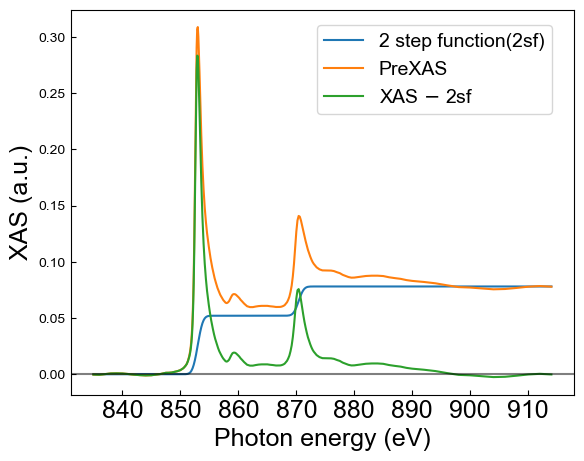

In [741]:
from scipy.special import erf

def step_func( x, x0, d ):
    return ( erf( ( x - x0 ) / d ) + 1 ) /2

def subtract_func( x, x01, x02, d, c ):
    return c * step_func( x, x01, d ) +  c/2 * step_func( x, x02, d)

def index_energy( energy, e0 ):
    for i, e in enumerate( energy ):
        if e >= e0:
            if abs( energy[ i ] - e0 ) <= abs( energy[ i - 1 ] - e0 ):
                return i
            else:
                return i - 1

i_post = index_energy( energy, post_edge_pe[0] ) #post-edgeのはじまりまで
#i_post = index_energy( energy, 880 ) #post-edgeのはじまりまで

from scipy.optimize import curve_fit
de=1

c, _ = curve_fit(
    lambda e, c: subtract_func( e, e1, e2, de, c ),
    energy[ i_post : ],
    xas1[ i_post : ]
    )
subtract1 = subtract_func( energy, e1, e2, de, c )
t2xas1 = xas1-subtract1

fig=plt.figure(figsize=(6.5, 5))
plt.plot( energy, subtract1 ,label='2 step function(2sf)')
plt.plot( energy, xas1 ,label='PreXAS')
plt.plot( energy, t2xas1 ,label='XAS $\minus$ 2sf')
plt.xlabel( "Photon energy (eV)" , fontsize=18)
plt.ylabel( "XAS (a.u.)" , fontsize=18)
plt.xticks(fontsize=18)
plt.axhline( y=0 , xmin=0 , xmax=1000  ,linestyle="-", color="black",alpha=0.5)
plt.legend(bbox_to_anchor=(0.45, 1.01), loc='upper left', borderaxespad=1, fontsize=14)
plt.yticks()
#plt.xlim(880,920)
#plt.ylim(-0.1,0.1)
plt.show()

台形公式による積分結果: -1.0336874401427352
累積積分の最終結果: 1.0336874401427245
r_110= 1.0147140420763845
r1_110= 1.028681618452013
q_110= -0.0616265639357443
900 eV以降のXASの平均値r: 1.0161228613596935
900 eV以降のXMCDの平均値q: -0.0616265639357443
m_orb_110= 0.0776087128545059
m_orb_110_ave= 0.07750111105222393
m_orb1_110= 0.07655493138824353


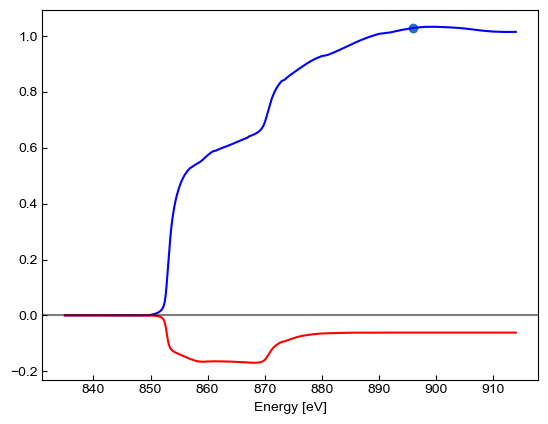

In [742]:
#積分を行ってくれる関数を定義
def integrate( x, y ):
    result = [ 0. ]
    for ix in range( len( x ) )[ 1: ]:
        result.append( simps( y[ :ix ], x[ :ix ] ) )
    return np.array( result )

#pe = 0 searchの関数の定義
def get_index( xs, x0 ):
    for i, x in enumerate( xs ):
        if x >= x0:
            if abs( xs[ i ] - x0 ) <= abs( xs[ i - 1 ] - x0 ):
                return i
            else:
                return i - 1

def index_zero( x, y, x_start, x_end ):
    iy_start = get_index( x, x_start )
    iy_end   = get_index( x, x_end )
    y_zero       = min( abs( y[ iy_start : iy_end ] ) )
    for iy, yy in enumerate( y ):
        if not iy_start <= iy <= iy_end: continue
        if abs( yy ) - y_zero <= 1e-7:
            return iy
# t2xas を 875 eV 以降で t2xas=0 となった以降で 0 に設定
def set_to_zero_after_zero_crossing(energy, t2xas1, post):
    # 875 eV以降を切り出し
    post = 875
    threshold_index = get_index(energy, post)
    energy_subset = energy[threshold_index:]
    t2xas1_subset = t2xas1[threshold_index:]
    
    # t2xas=0 を探す
    zero_crossing_index = np.where(t2xas1_subset <= 0)[0]
    if len(zero_crossing_index) > 0:
        first_zero_index = zero_crossing_index[0] + threshold_index
        t2xas1[first_zero_index:] = 0
    return t2xas1

# 845 eV以前の値を0にする処理################################################################3
pre_threshold_energy = pre_0_start  # エネルギーの閾値
# energyがthreshold_energy未満のインデックスを取得
pre_zero_indices = np.where(energy <= pre_threshold_energy)
# XAS (t2xas) と MCD (xmcd) の845 eV以前を0に設定
t2xas1[pre_zero_indices] = 0
xmcd1[pre_zero_indices] = 0

#積分
int_xas1 = integrate( energy, t2xas1 )
int_xmcd1 = integrate( energy, xmcd1)

# 890 eV以降を0にする処理#########################################################################
threshold_energy = post_0_start  # エネルギー閾値
#threshold_energy_xas = 900 
# energyがthreshold_energy以上のインデックスを取得
zero_indices = np.where(energy >= threshold_energy)
# XASスペクトル（xmcd）の890 eV以降を0に設定
t2xas1 = set_to_zero_after_zero_crossing(energy, t2xas1, 875)
#int_xas[zero_indices_xas] = int_xas[zero_indices_xas[0][0]]  # 積分値を維持（最後の値を保持)
# MCDスペクトル（xmcd）の890 eV以降を0に設定
xmcd1[zero_indices] = 0
int_xmcd1[zero_indices] = int_xmcd1[zero_indices[0][0]]  # 積分値を維持（最後の値を保持)

#xas=0となるところまでの積分
i1_zero1 = index_zero( energy[ 1 : ], t2xas1, 870 , 900 )

# 台形公式で積分を計算
integral1 = np.trapz(energy, t2xas1)
# 積分の累積計算
cumulative_integral1 = np.array([np.trapz(y=t2xas1[:i+1], x=energy[:i+1]) for i in range(len(energy))])

# postedge start eV以降のXASとXMCDの平均値を計算
i_900eV = get_index(energy, post_edge_range[0])  # 900 eV以降のインデックス取得
avg_int_xas_after_900_1 = np.mean(int_xas1[i_900eV:])
avg_int_xmcd_after_900_1 = np.mean(int_xmcd1[i_900eV:])

print(f"台形公式による積分結果: {integral1}")
print(f"累積積分の最終結果: {cumulative_integral1[-1]}")

#総和則の係数
r1_110 = int_xas1[ i1_zero ] 
r_110=int_xas1[-1] 
q_110=int_xmcd1[-1]
r_110_ave = avg_int_xas_after_900_1
q_110_ave = avg_int_xmcd_after_900_1

m_orb_110=-4*(q_110)*1.66/(3*(r_110))/ (2*np.cos(np.radians(30)))
m_orb1_110=-4*(q_110)*1.66/(3*(r1_110))/ (2*np.cos(np.radians(30)))
m_orb_110_ave=-4*(q_110_ave)*1.66/(3*(r_110_ave))/ (2*np.cos(np.radians(30)))

print( 'r_110=' , r_110 )
print( 'r1_110=' , r1_110 )
print( 'q_110=' , q_110 ) 
print(f"900 eV以降のXASの平均値r: {avg_int_xas_after_900_1}")
print(f"900 eV以降のXMCDの平均値q: {avg_int_xmcd_after_900_1}")
print( 'm_orb_110=' , m_orb_110)
print( 'm_orb_110_ave=' , m_orb_110_ave)
print( 'm_orb1_110=' , m_orb1_110)

plt.plot( energy[i1_zero] , r1_110 , 'o')
plt.plot( energy, int_xas1, 'blue')
plt.plot( energy, int_xmcd1 ,'red')
plt.xlabel( "Energy [eV]" )
plt.axhline( y=0 , xmin=0 , xmax=100  ,linestyle="-", color="black", alpha=0.5)
plt.show()

(835, 848)
(908, 915)
p_110= -0.16841367467163773
q_110= -0.0616265639357443
r_110= 1.0147140420763845
r1_110= 1.028681618452013

Niの文献値: spin:0.605 , orbit:0.0507 , ratio: 0.08380165289256199
全体で積分した結果
m_spin (μB) = 0.7215781730895027
m_orb = 0.0776087128545059
m_orb/m_spin = 0.10755413030609993

post-edge範囲でXAS_Intensity=0となる点までで積分した結果
m_spin1 = 0.7117804883026579
m_orb1 = 0.07655493138824353
m_orb/m_spin = 0.10755413030609995

積分値を平均した結果
m_spin_ave = 0.7205777298524485
m_orb_ave = 0.07750111105222393
m_orb/m_spin_ave = 0.10755413030609995


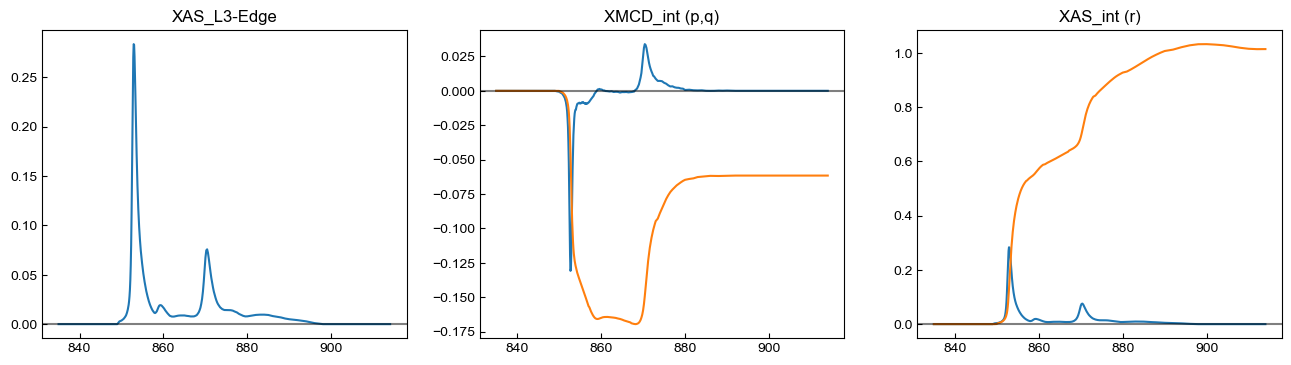

In [743]:
def get_index( xs, x0 ):
    for i, x in enumerate( xs ):
        if x >= x0:
            if abs( xs[ i ] - x0 ) <= abs( xs[ i - 1 ] - x0 ):
                return i
            else:
                return i - 1

def index_zero( x, y, x_start, x_end ):
    iy_start = get_index( x, x_start )
    iy_end   = get_index( x, x_end )
    y_zero       = min( abs( y[ iy_start : iy_end ] ) )
    for iy, yy in enumerate( y ):
        if not iy_start <= iy <= iy_end: continue
        if abs( yy ) - y_zero <= 1e-7:
            return iy

i_zero1 = index_zero( energy[ 1 : ], np.diff( t2xas1, n=1 ), 865 , 870 )
p_110 = int_xmcd1[ i_zero ]

print(pre_edge_range)
print(post_edge_range)
print( 'p_110=' , p_110 )
print( 'q_110=' , q_110 )
print( 'r_110=' , r_110 )
print( 'r1_110=' , r1_110 )

m_spin_110 = -( 6*p_110 - 4*q_110 ) * 1.66 / r_110 / (2*np.cos(np.radians(30)))
m_spin1_110 = -( 6*p_110 - 4*q_110 ) * 1.66 / r1_110 / (2*np.cos(np.radians(30)))
m_spin_110_ave = -( 6*p_110 - 4*q_110_ave ) * 1.66 / r_110_ave / (2*np.cos(np.radians(30)))
ratio = 0.0507 / 0.605

print('')
print( 'Niの文献値: spin:0.605 , orbit:0.0507 , ratio:' , ratio)
print('全体で積分した結果')
print( 'm_spin (μB) =' , m_spin_110)
print( 'm_orb =' , m_orb_110)
print( 'm_orb/m_spin =' , m_orb_110/m_spin_110)
print('')
print('post-edge範囲でXAS_Intensity=0となる点までで積分した結果')
print( 'm_spin1 =' , m_spin1_110)
print( 'm_orb1 =' , m_orb1_110)
print( 'm_orb/m_spin =' , m_orb1_110/m_spin1_110)
print('')
print('積分値を平均した結果')
print( 'm_spin_ave =' , m_spin_110_ave)
print( 'm_orb_ave =' , m_orb_110_ave)
print( 'm_orb/m_spin_ave =' , m_orb_110_ave/m_spin_110_ave)

fig = plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot( energy, t2xas1 )
#plt.plot( energy[i_zero ], t2xas[ i_zero ], "o" )
plt.axhline( y=0 , xmin=0 , xmax=100  ,linestyle="-", color="black", alpha=0.5)
plt.title("XAS_L3-Edge")

plt.subplot(1, 3, 2)
plt.plot( energy, xmcd1 )
#plt.plot( energy[i_zero ], xmcd[ i_zero ], "o" ) 
plt.plot( energy, int_xmcd1 )
#plt.plot( energy[i_zero ], int_xmcd[ i_zero ], "o" )
#plt.xlim(900,930)
#plt.ylim(-0.425,-0.375)
plt.axhline( y=0 , xmin=0 , xmax=100  ,linestyle="-", color="black", alpha=0.5)
plt.title("XMCD_int (p,q)")

plt.subplot(1, 3, 3)
plt.plot( energy, t2xas1 )
plt.plot( energy, int_xas1 )
plt.axhline( y=0 , xmin=0 , xmax=100  ,linestyle="-", color="black", alpha=0.5)
plt.title("XAS_int (r)")
plt.show()

##########データファイルの作成##################################################
with open(f'{path}/XMCD/analysis/Ni/{filename}_{post_edge_range}.txt','a') as f:
    f.write(f"pre-edge \t\t:{pre_edge_range}\n\n")
    f.write(f"post-edge \t\t:{post_edge_range}\n\n")
    f.write(f"p \t\t:{p_110}\n\n")
    f.write(f"q \t\t:{q_110}\n\n")
    f.write(f"r \t\t:{r_110}\n\n")
    f.write(f"r1 \t\t:{r1_110}\n\n")
    f.write(f"q_ave \t\t:{q_110_ave}\n\n")
    f.write(f"r_ave \t\t:{r_110_ave}\n\n")
    f.write(f"\n")
    f.write(f"Niの文献値: spin:0.605 , orbit:0.0507 , ratio:{ratio}\n")
    f.write(f"全体で積分した結果\n")
    f.write(f"m_spin (μB) =:{m_spin_110}\n")
    f.write(f"m_orb (μB) =:{m_orb_110}\n")
    f.write(f"m_orb/m_spin =:{m_orb_110/m_spin_110}\n")
    f.write(f"\n\n")
    f.write(f"post-edge範囲でXAS_Intensity=0となる点までで積分した結果\n")
    f.write(f"m_spin (μB) =:{m_spin1_110}\n")
    f.write(f"m_orb (μB) =:{m_orb1_110}\n")
    f.write(f"m_orb/m_spin =:{m_orb1_110/m_spin1_110}\n")
    f.write("\n")
    f.write(f"積分値を平均した結果\n")
    f.write(f"m_spin (μB) =:{m_spin_110_ave}\n")
    f.write(f"m_orb (μB) =:{m_orb_110_ave}\n")
    f.write(f"m_orb/m_spin =:{m_orb_110_ave/m_spin_110_ave}\n")
    f.write("\n")

#fig.savefig(f'{save_path}/{filename}_{post_edge_range}.png',format="png", bbox_inches="tight", pad_inches=0.1)

# 方位差

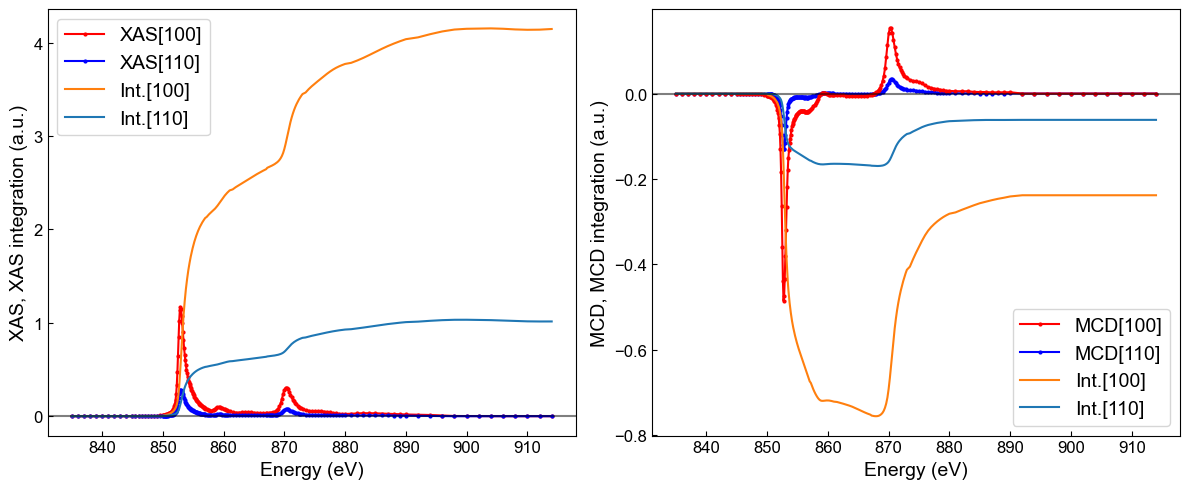

(835, 848)
(908, 915)
849
890
[100]##################################################################################
Niの文献値: spin:0.605 , orbit:0.0507 , ratio: 0.08380165289256199
全体で積分した結果
m_spin (μB) = 0.8224970312948385
m_orb = 0.0733778047764817
m_orb/m_spin = 0.08921345851056105

post-edge範囲でXAS_Intensity=0となる点までで積分した結果
m_spin1 = 0.827700492875656
m_orb1 = 0.07384202358033326
m_orb/m_spin = 0.08921345851056105

積分値を平均した結果
m_spin_ave = 0.8226666267905187
m_orb_ave = 0.07339293497719915
m_orb/m_spin_ave = 0.08921345851056105
[110]#############################################################################################
Niの文献値: spin:0.605 , orbit:0.0507 , ratio: 0.08380165289256199
全体で積分した結果
m_spin (μB) = 0.7215781730895027
m_orb = 0.0776087128545059
m_orb/m_spin = 0.10755413030609993

post-edge範囲でXAS_Intensity=0となる点までで積分した結果
m_spin1 = 0.7117804883026579
m_orb1 = 0.07655493138824353
m_orb/m_spin = 0.10755413030609995

積分値を平均した結果
m_spin_ave = 0.7205777298524485
m_orb_ave = 0.07750

In [744]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 左側のプロット（XAS と int_XAS）
ax1 = axes[0]

# XAS

line2, = ax1.plot(energy, t2xas, 'o-', ms=2, color='red', label='XAS[100]')
line1, = ax1.plot(energy, t2xas1, 'o-', ms=2, color='blue', label='XAS[110]')
# Integral XAS
line3, = ax1.plot(energy, int_xas, '-', color='#ff7f0e', label='Int.[100]')
line4, = ax1.plot(energy, int_xas1, '-', color='#1f77b4', label='Int.[110]')

ax1.axhline(y=0, linestyle="-", color="black", alpha=0.5)
ax1.set_xlabel("Energy (eV)", fontsize=14)
ax1.set_ylabel("XAS, XAS integration (a.u.)", fontsize=14)

# 凡例（順番を指定）
ax1.legend([line2, line1, line3, line4],  # 順序を [XAS[100], XAS[110], Int.[100], Int.[110]] に指定
           ['XAS[100]', 'XAS[110]', 'Int.[100]', 'Int.[110]'],
           loc='upper left', fontsize=14)
ax1.tick_params(axis='both', labelsize=12)

# 右側のプロット（MCD と int_MCD）
ax2 = axes[1]

# MCD
line5, = ax2.plot(energy, xmcd1, 'o-', ms=2, color='blue', label='MCD[110]')
line6, = ax2.plot(energy, xmcd, 'o-', ms=2, color='red', label='MCD[100]')


# Integral MCD
line7, = ax2.plot(energy, int_xmcd, '-', color='#ff7f0e', label='Int.[100]')
line8, = ax2.plot(energy, int_xmcd1, '-', color='#1f77b4', label='Int.[110]')

ax2.axhline(y=0, linestyle="-", color="black", alpha=0.5)
#ax2.axvline(x=850, linestyle="-", color="black", alpha=0.5)
ax2.set_xlabel("Energy (eV)", fontsize=14)
ax2.set_ylabel("MCD, MCD integration (a.u.)", fontsize=14)

# 凡例（順番を指定）
ax2.legend([line6, line5, line7, line8],  # 順序を [MCD[100], MCD[110], Int.[100], Int.[110]] に指定
           ['MCD[100]', 'MCD[110]', 'Int.[100]', 'Int.[110]'],
           loc='lower right', fontsize=14)
ax2.tick_params(axis='both', labelsize=12)

plt.tight_layout()

# 画像の保存
fig.savefig(f'{save_path}/{filename}_both.png', format="png", bbox_inches="tight", pad_inches=0.1)
plt.show()

# データの出力
print(pre_edge_range)
print(post_edge_range)
print(pre_0_start)
print(post_0_start)
print('[100]##################################################################################')
print('Niの文献値: spin:0.605 , orbit:0.0507 , ratio:', ratio)
print('全体で積分した結果')
print('m_spin (μB) =', m_spin)
print('m_orb =', m_orb)
print('m_orb/m_spin =', m_orb / m_spin)
print('')
print('post-edge範囲でXAS_Intensity=0となる点までで積分した結果')
print('m_spin1 =', m_spin1)
print('m_orb1 =', m_orb1)
print('m_orb/m_spin =', m_orb1 / m_spin1)
print('')
print('積分値を平均した結果')
print('m_spin_ave =', m_spin_ave)
print('m_orb_ave =', m_orb_ave)
print('m_orb/m_spin_ave =', m_orb_ave / m_spin_ave)

print('[110]#############################################################################################')
print('Niの文献値: spin:0.605 , orbit:0.0507 , ratio:', ratio)
print('全体で積分した結果')
print('m_spin (μB) =', m_spin_110)
print('m_orb =', m_orb_110)
print('m_orb/m_spin =', m_orb_110 / m_spin_110)
print('')
print('post-edge範囲でXAS_Intensity=0となる点までで積分した結果')
print('m_spin1 =', m_spin1_110)
print('m_orb1 =', m_orb1_110)
print('m_orb/m_spin =', m_orb1_110 / m_spin1_110)
print('')
print('積分値を平均した結果')
print('m_spin_ave =', m_spin_110_ave)
print('m_orb_ave =', m_orb_110_ave)
print('m_orb/m_spin_ave =', m_orb_110_ave / m_spin_110_ave)

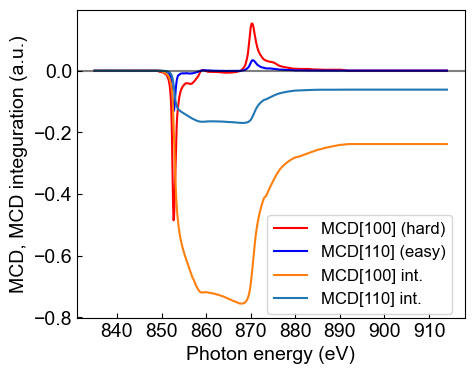

In [745]:
fig=plt.figure(figsize=(5, 4))


plt.plot(energy,xmcd,'-',ms=3,color='RED',label='MCD[100] (hard)')
plt.plot(energy,xmcd1,'-',ms=3,color='BLUE',label='MCD[110] (easy)')
plt.plot(energy,int_xmcd,'-',ms=3,color='#ff7f0e',label='MCD[100] int.')
plt.plot(energy,int_xmcd1,'-',ms=3,color='#1f77b4',label='MCD[110] int.')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Photon energy (eV)', fontsize=14)
plt.ylabel('MCD, MCD integuration (a.u.)', fontsize=14)
plt.axhline( y=0 , xmin=0 , xmax=1000  ,linestyle="-", color="black",alpha=0.5)
plt.legend(bbox_to_anchor=(0.47, 0.36), loc='upper left', fontsize=12)
plt.show()

# 画像の保存
fig.savefig(f'{save_path}/graph_XMCD_{filename}.png', format="png", bbox_inches="tight", pad_inches=0.1)
plt.show()